In [1]:
import os
import sys
import time

import numpy as np
import torch

import pandas as pd
import librosa

import matplotlib.pyplot as plt

import torchnet.meter as tnt
from collections import OrderedDict
import importlib
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

from types import SimpleNamespace

import ai8x

from msnoise import MSnoise
import msnoise
from signalmixer import signalmixer

from IPython.display import clear_output
from scipy.io.wavfile import write
import IPython

## msnoise

In [2]:
noise_train_folder = "/data_ssd/MSnoise/raw/noise_train/"
noise_test_folder = "/data_ssd/MSnoise/raw/noise_test/"

train_test_folders = [noise_train_folder, noise_test_folder]

In [9]:
labels = ['AirConditioner', 'AirportAnnouncements',
                'Babble', 'Bus', 'CafeTeria', 'Car',
                'CopyMachine', 'Field', 'Hallway', 'Kitchen',
                'LivingRoom', 'Metro', 'Munching', 'NeighborSpeaking',
                'Office', 'Park', 'Restaurant', 'ShuttingDoor',
                'Square', 'SqueakyChair', 'Station', 'Traffic',
                'Typing', 'VacuumCleaner', 'WasherDryer', 'Washing', 'TradeShow']

In [10]:
def quantize_audio(data, num_bits=8):
    """Quantize audio
    """
    step_size = 2.0 / 2**(num_bits)
    max_val = 2**(num_bits) - 1
    q_data = np.round((data - (-1.0)) / step_size)
    q_data = np.clip(q_data, 0, max_val)

    return np.uint8(q_data)

In [20]:
quantize = False

data_in = []
data_type = []
data_class = []
rms_val = []

for i,label in enumerate(labels):
    train_count = 0
    test_count = 0
    for folder in train_test_folders:
        for record_name in os.listdir(folder):
            if record_name.split('_')[0] in label:
                record_path = os.path.join(folder, record_name)
                record, fs = librosa.load(record_path, offset=0, sr=None)

                if quantize:
                    data_in.append(quantize_audio(record))
                else:
                    data_in.append(record)

                if (folder == noise_train_folder):
                    data_type.append(0)
                elif (folder == noise_test_folder):
                    data_type.append(1)

                data_class.append(i)
                rms_val.append(np.mean(record**2)**0.5)

In [21]:
bool_list = [i == 0 for i in data_type]
idx = [i for i, x in enumerate(bool_list) if x]

data_in = [data_in[i] for i in idx]
data_type = [data_type[i] for i in idx]
data_class = [data_class[i] for i in idx]
rms_val = [rms_val[i] for i in idx]


In [22]:
fs = 16000
noise_time_step = 0.25

rec_len = len(data_in[0])
max_start_time = (rec_len / fs - 1) - (rec_len / fs % noise_time_step)

In [29]:
rec_len

525380

In [30]:
max_start_time

31.75

In [31]:
int((max_start_time+noise_time_step)*fs)

512000

In [32]:
int(noise_time_step*fs)

4000

In [41]:
fs = 16000
noise_time_step = 0.25

rec_len = len(data_in[0])
max_start_time = (rec_len / fs - 1) - (rec_len / fs % noise_time_step)
max_start = int((max_start_time+noise_time_step)*fs)

start_pt = np.random.randint(0, max_start)
end_pt = start_pt + exp_len

self.data[index][start_pt:end_pt]

55609

In [33]:
for start_time in np.arange(0, int((max_start_time+noise_time_step)*fs), int(noise_time_step*fs)):
    print(start_time)
    end_time = start_time + fs
    audio_seq = data_in[start_time:end_time]


0
4000
8000
12000
16000
20000
24000
28000
32000
36000
40000
44000
48000
52000
56000
60000
64000
68000
72000
76000
80000
84000
88000
92000
96000
100000
104000
108000
112000
116000
120000
124000
128000
132000
136000
140000
144000
148000
152000
156000
160000
164000
168000
172000
176000
180000
184000
188000
192000
196000
200000
204000
208000
212000
216000
220000
224000
228000
232000
236000
240000
244000
248000
252000
256000
260000
264000
268000
272000
276000
280000
284000
288000
292000
296000
300000
304000
308000
312000
316000
320000
324000
328000
332000
336000
340000
344000
348000
352000
356000
360000
364000
368000
372000
376000
380000
384000
388000
392000
396000
400000
404000
408000
412000
416000
420000
424000
428000
432000
436000
440000
444000
448000
452000
456000
460000
464000
468000
472000
476000
480000
484000
488000
492000
496000
500000
504000
508000


In [18]:
audio_seq

[]

In [3]:
dataset = MSnoise(root = '/data_ssd', classes = ["Typing"], d_type = 'test', len = 11005, remove_unknowns=True,
                        transform=None, quantize=False, download=False)

data_len: 16384
Labels: ['AirConditioner', 'AirportAnnouncements', 'Babble', 'Bus', 'CafeTeria', 'Car', 'CopyMachine', 'Field', 'Hallway', 'Kitchen', 'LivingRoom', 'Metro', 'Munching', 'NeighborSpeaking', 'Office', 'Park', 'Restaurant', 'ShuttingDoor', 'Square', 'SqueakyChair', 'Station', 'TradeShow', 'Traffic', 'Typing', 'VacuumCleaner', 'WasherDryer', 'Washing']


Class Typing, 23
Typing: 0




In [4]:
dataset.data

[array([-0.00143433, -0.00231934, -0.0022583 , ..., -0.00183105,
        -0.00198364, -0.00149536], dtype=float32),
 array([ 3.0517578e-05, -9.1552734e-05, -6.1035156e-05, ...,
         5.7983398e-04,  5.1879883e-04,  5.4931641e-04], dtype=float32)]

In [21]:
dataset[1]

(tensor([[-5.4932e-04,  4.8828e-04, -1.3123e-03,  ..., -3.3264e-03,
           1.3123e-03,  1.3428e-03],
         [-9.7656e-04,  7.0190e-04, -1.5869e-03,  ..., -3.5400e-03,
           1.4648e-03,  1.8311e-04],
         [ 2.1362e-04,  5.4932e-04,  5.1880e-04,  ..., -9.1553e-04,
           9.4604e-04, -1.5259e-04],
         ...,
         [ 3.3569e-04, -8.2397e-04, -8.2397e-04,  ...,  6.7139e-04,
          -5.4932e-04,  2.1362e-04],
         [ 3.3569e-04, -6.4087e-04, -1.2817e-03,  ...,  1.2207e-03,
           9.1553e-05,  6.7139e-04],
         [ 2.4414e-04, -1.2207e-04, -2.8992e-03,  ...,  1.8311e-04,
          -9.4604e-04,  5.4932e-04]]),
 0)

# deneme

In [2]:
'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v2_0911Speed_DynAug","qat_best.pth.tar")             
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"
'''
'''
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug","qat_best.pth.tar")              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"
'''

trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/","qat_best.pth.tar")
mod = importlib.import_module("ai85nasnet_kws20_res_1")
model_file = "ai85nasnet_kws20_res_1"

dataset = importlib.import_module("kws20")

In [3]:
classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

model files

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

'''
model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)
'''
'''
model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)
'''

model = mod.AI85NASNET_KWS20_RES_1(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)


checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [5]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

In [6]:
# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))
_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]



Processing test...
test set: 33015 elements
Class up (# 31): 1275 elements
Class down (# 5): 1218 elements
Class left (# 15): 1236 elements
Class right (# 23): 1188 elements
Class stop (# 27): 1233 elements
Class go (# 11): 1206 elements
Class yes (# 34): 1257 elements
Class no (# 19): 1215 elements
Class on (# 21): 1188 elements
Class off (# 20): 1206 elements
Class one (# 22): 1197 elements
Class two (# 30): 1272 elements
Class three (# 28): 1215 elements
Class four (# 10): 1200 elements
Class five (# 7): 1335 elements
Class six (# 26): 1182 elements
Class seven (# 24): 1218 elements
Class eight (# 6): 1224 elements
Class nine (# 18): 1224 elements
Class zero (# 35): 1254 elements
Class UNKNOWN: 8472 elements


In [7]:
originals = list(range(0, len(test_dataset), 3))
test_dataset.data = test_dataset.data[originals]
test_dataset.targets = test_dataset.targets[originals]

In [8]:
noise_list = ['AirConditioner',
 'AirportAnnouncements',
 'Babble',
 'CopyMachine',
 'Munching',
 'NeighborSpeaking',
 'ShuttingDoor',
 'Typing',
 'VacuumCleaner',
 'TradeShow',
 'WhiteNoise']

### Evaluation

In [9]:
def evaluate(db, noise, noise_kind):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device)
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
    outputs_all = np.zeros((len(test_dataset), 21))
    targets_all = np.zeros((len(test_dataset)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:

        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = None, snr = db, noise_kind = noise_kind, 
                                        quantized_noise = False, transform = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', len = 11005,remove_unknowns=True,
                        transform=None, quantize=False, download=False)

            mixed_signals = signalmixer(test_dataset, noise = True, noise_dataset = noise_dataset, snr = db, noise_kind = noise_kind, 
                    quantized_noise = False, transform = None)
            
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            write(f'/home/merveeyuboglu/Github/ai8x-training/codes/audios/mixed_{noise_kind}_{db}.wav', 16384, np.array(inputs[0]).flatten('F'))
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
            targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
            
    print("Total Accuracy: ", acc)
    return acc

In [10]:
def snr_testing(noise = False, noise_kind = None):

    if noise == False:
        db = None

    time_s = time.time()
    print("Started evaluating :", trained_checkpoint_path)

    if noise == False:
        accuracies = np.zeros(1)
        snr = np.zeros(1)

        accuracies[0] = evaluate(db, noise, noise_kind)
        snr[0] = None
        
        dur = time.time() - time_s
        print(f'Finished in {dur:.3f} seconds.')
        return accuracies, snr
    
    accuracies = np.zeros(36)
    snr = np.zeros(36)

    for idx, db in enumerate(range(-5,31)):
        print("Evaluating SNR levels of", db)
        accuracies[idx] = evaluate(db, noise, noise_kind)
        snr[idx] = db
    
    dur = time.time() - time_s
    print(f'Finished in {dur:.3f} seconds.')
    return accuracies, snr

In [11]:
def benchmark(noise_kinds):

    num = len(noise_kinds) + 1

    snr = np.zeros((num, 36))
    accuracies = np.zeros((num, 36))

    for idx, n in enumerate(noise_kinds):

        print(f'{n} Noise Evaluation')
        
        accuracies[idx], snr[idx] = snr_testing(noise = True, noise_kind = n)

    accuracies[-1], snr[-1] = snr_testing(noise = False)

    return accuracies, snr

In [12]:
accuracies_w, snr_w = benchmark(noise_list)

AirConditioner Noise Evaluation
Started evaluating : /home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/qat_best.pth.tar
Evaluating SNR levels of -5
data_len: 16384
Labels: ['AirConditioner', 'AirportAnnouncements', 'Babble', 'Bus', 'CafeTeria', 'Car', 'CopyMachine', 'Field', 'Hallway', 'Kitchen', 'LivingRoom', 'Metro', 'Munching', 'NeighborSpeaking', 'Office', 'Park', 'Restaurant', 'ShuttingDoor', 'Square', 'SqueakyChair', 'Station', 'TradeShow', 'Traffic', 'Typing', 'VacuumCleaner', 'WasherDryer', 'Washing']




Class AirConditioner, 0
AirConditioner: 0


Batch: [ 0 / 11005 ]
Accuracy:  46.484375
Batch: [ 256 / 11005 ]
Accuracy:  44.3359375
Batch: [ 512 / 11005 ]
Accuracy:  44.921875
Batch: [ 768 / 11005 ]
Accuracy:  39.2578125
Batch: [ 1024 / 11005 ]
Accuracy:  43.203125
Batch: [ 1280 / 11005 ]
Accuracy:  43.9453125
Batch: [ 1536 / 11005 ]
Accuracy:  43.97321428571429
Batch: [ 1792 / 11005 ]
Accuracy:  44.04296875
Batch: [ 2048 / 11005 ]
Accuracy:  43.44618055555556
Batch: [ 2304 / 11005 ]
Accuracy:  42.69531250000001
Batch: [ 2560 / 11005 ]
Accuracy:  42.22301136363637
Batch: [ 2816 / 11005 ]
Accuracy:  41.373697916666664
Batch: [ 3072 / 11005 ]
Accuracy:  40.715144230769226
Batch: [ 3328 / 11005 ]
Accuracy:  41.796875
Batch: [ 3584 / 11005 ]
Accuracy:  41.69270833333333
Batch: [ 3840 / 11005 ]
Accuracy:  42.4072265625
Batch: [ 4096 / 11005 ]
Accuracy:  43.12959558823529
Batch: [ 4352 / 11005 ]
Accuracy:  43.44618055555556
Batch: [ 4608 / 11005 ]
Accuracy:  43.8733552631579
Batch: [ 4864 /

In [13]:
snr = range(-5,31)

csv ={}

for idx, i in enumerate(noise_list):
    csv[i] = accuracies_w[idx]
    
csv_list = [] 

csv_list.append(['raw', 'None', accuracies_w[-1][0]])
for i in csv.keys():
    for idx, j in enumerate(csv[i]):
        csv_list.append([i, snr[idx], j])

df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_file}'])

In [14]:
df

,Type,SNR (dB),ai85nasnet_kws20_res_1
0,raw,None,93.766470
1,AirConditioner,-5,45.479328
2,AirConditioner,-4,50.567924
3,AirConditioner,-3,55.874602
4,AirConditioner,-2,60.245343
...,...,...,...
392,WhiteNoise,26,93.421172
393,WhiteNoise,27,93.484780
394,WhiteNoise,28,93.521127
395,WhiteNoise,29,93.466606


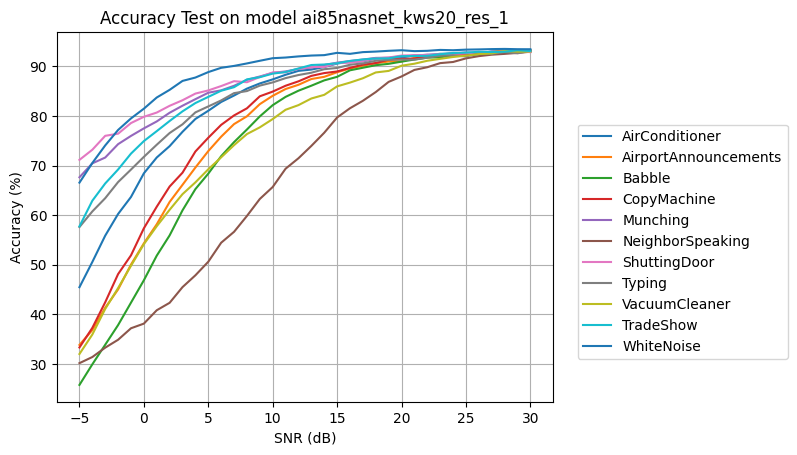

In [16]:
def plot_values(model_number):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(df['Type'].values[1:]): 
            if i == noise:
                acc_list.append(df[model_number][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

snr = range(-5,31)

for model_num in df.columns[2:]:
    accuracies_values = plot_values(model_num)
    plt.figure()
    plt.grid()
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}') #duzelecek
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                         loc='upper left', borderaxespad=0.)

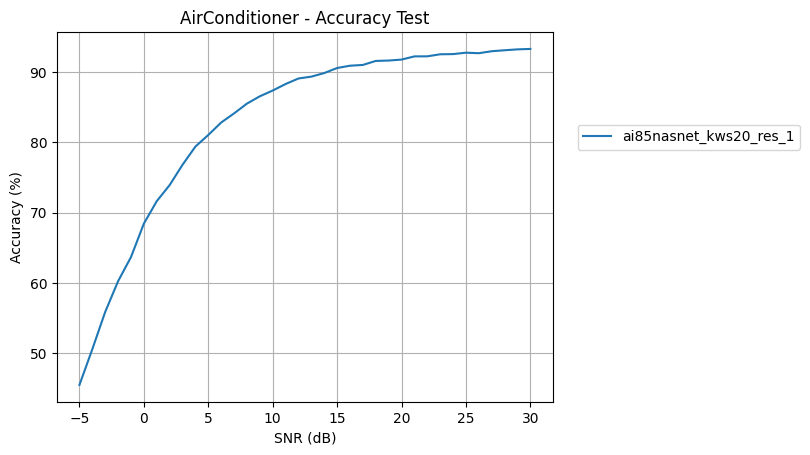

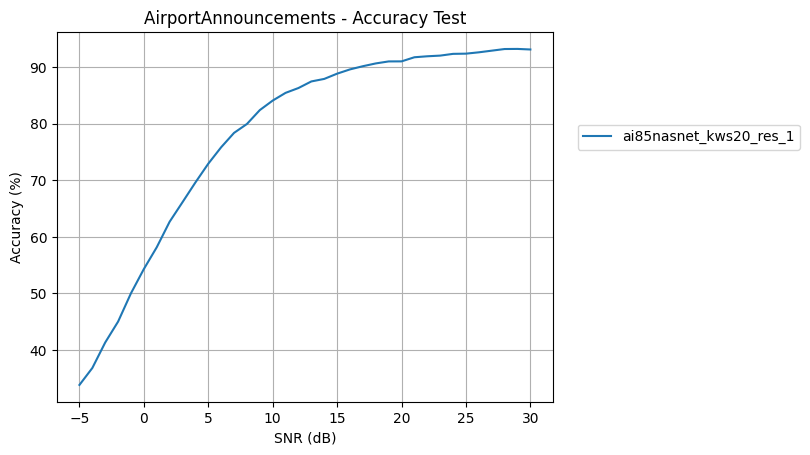

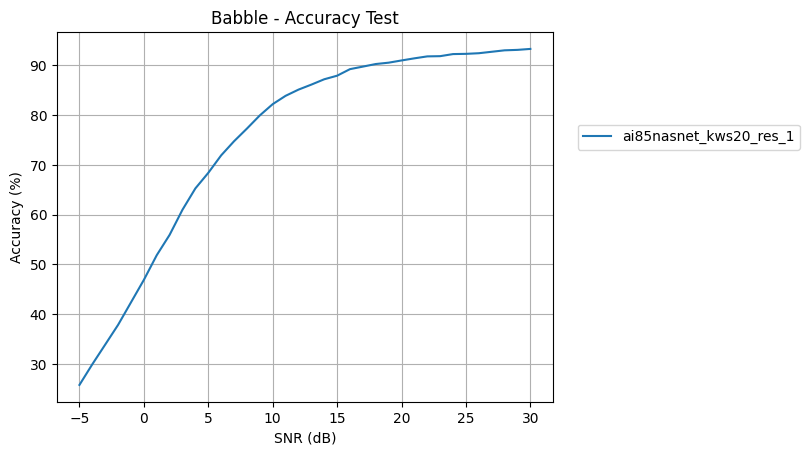

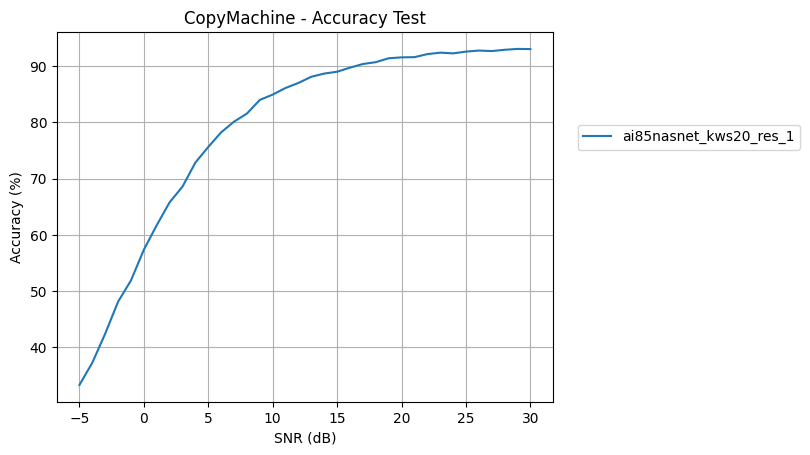

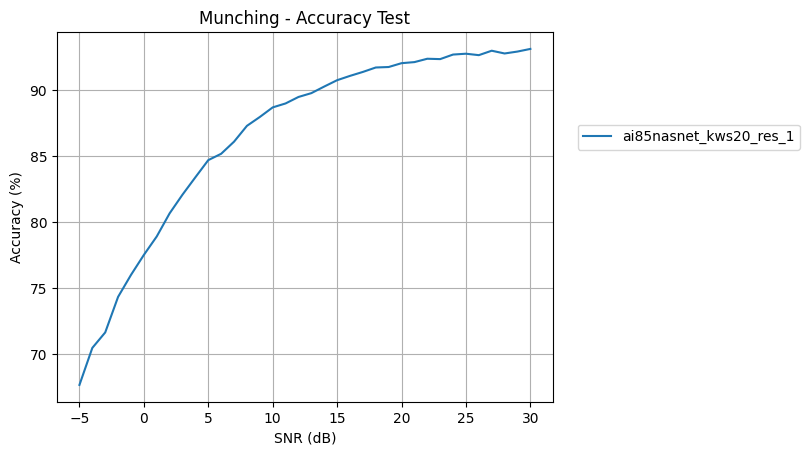

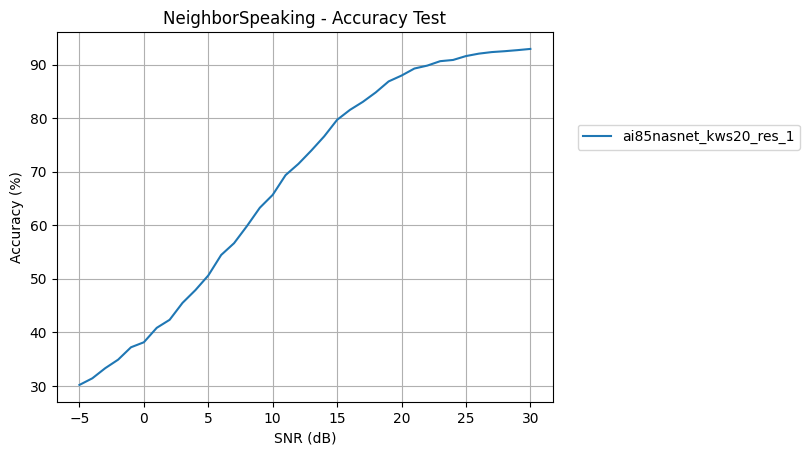

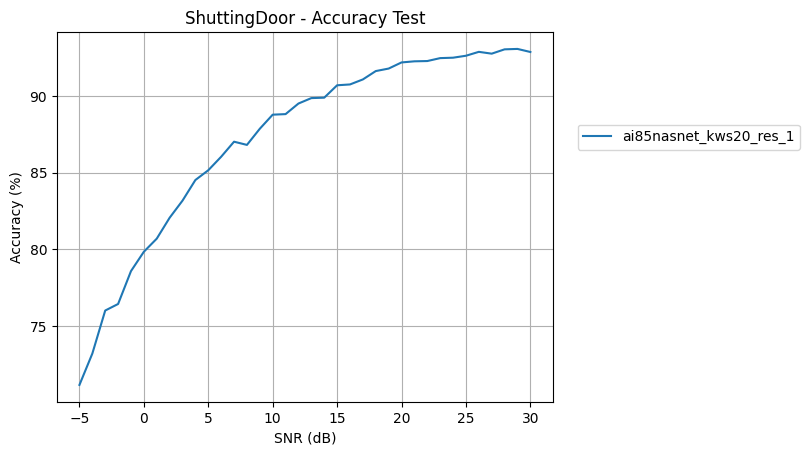

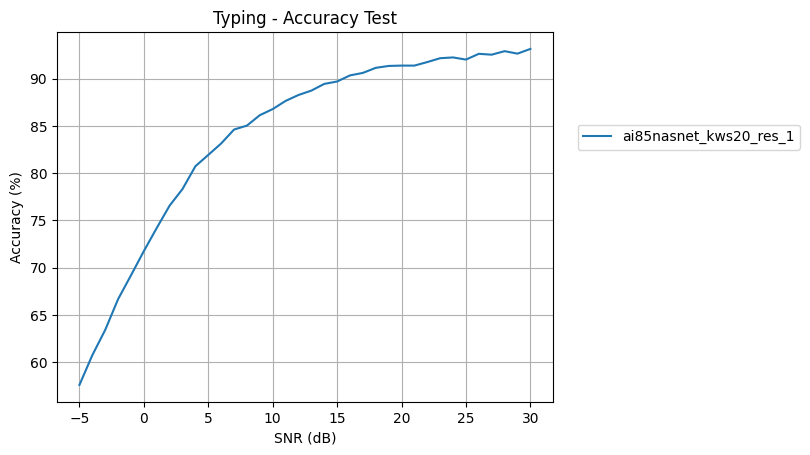

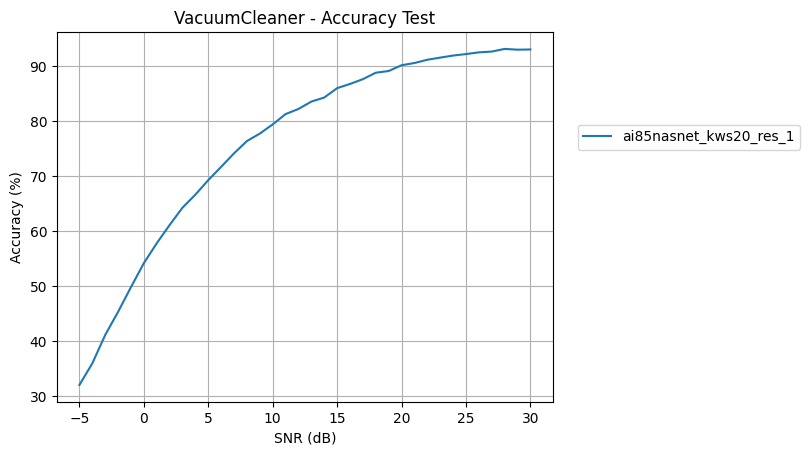

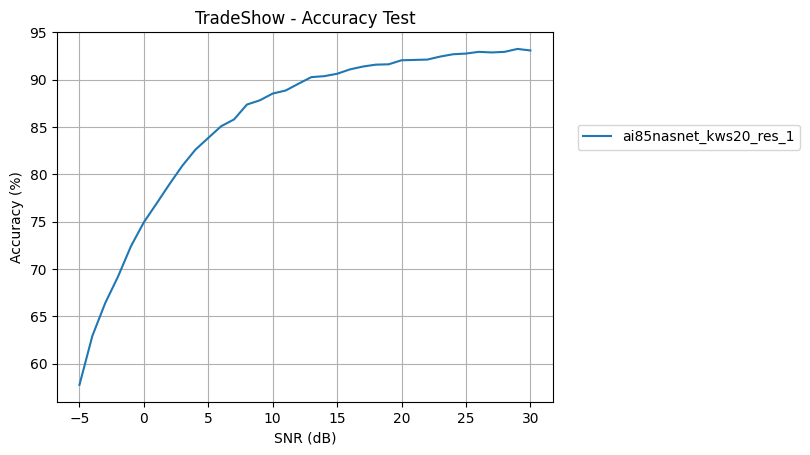

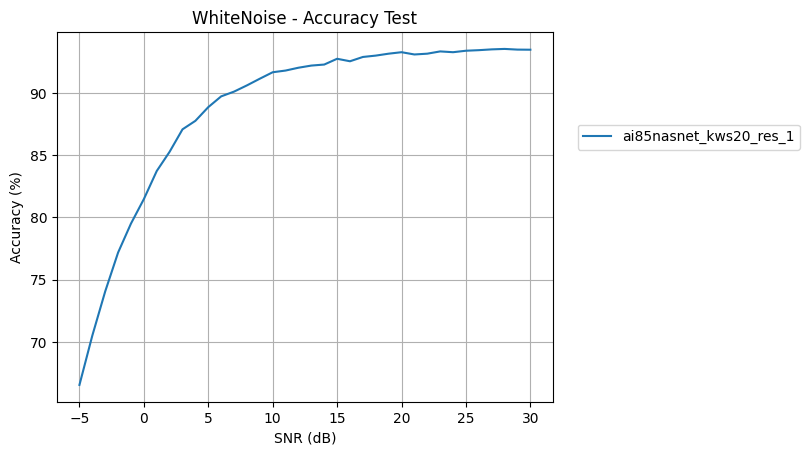

In [17]:
snr = range(-5,31)
acc_list = []
for model_num in df.columns[2:]:
    acc_list.append(plot_values(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid()
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr , model[noise])

    plt.legend(df.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)